In [8]:
import datetime

import pandas as pd
import matplotlib.pyplot as plt

from setup import get_task_data



In [28]:
df_amd = pd.read_csv(get_task_data('AMD.csv'), index_col='Date', parse_dates=True)
df_intel = pd.read_csv(get_task_data('INTC.csv'), index_col='Date', parse_dates=True)
print(df_intel.sample(5))
df_amd.sample(5)

                 Open       High        Low      Close  Adj Close    Volume
Date                                                                       
2020-02-19  66.389999  67.199997  66.180000  67.110001  60.285435  13551200
2021-05-26  57.049999  57.230000  56.590000  56.919998  52.785927  15173600
2023-03-20  29.799999  29.900000  28.629999  29.160000  28.842133  38780100
2023-08-14  34.669998  35.709999  34.470001  35.680000  35.563061  36896100
2019-02-05  49.180000  50.720001  49.180000  50.009998  43.616089  31641600


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2004-06-09,16.3200,16.3500,15.48000,15.51000,15.51000,14821000
1983-01-13,0.0000,7.3750,7.21875,7.28125,7.28125,506800
2000-12-18,16.0000,16.1250,15.00000,15.25000,15.25000,4327800
1995-10-13,14.1250,14.2500,13.68750,13.81250,13.81250,2244800
1985-10-02,12.9375,12.9375,12.12500,12.12500,12.12500,1074600


In [29]:
amd_max, amd_min = df_amd.index.max(), df_amd.index.min()
amd_min, amd_max

(Timestamp('1980-03-17 00:00:00'), Timestamp('2023-10-06 00:00:00'))

### Get last 3 years data

In [31]:
def filter_dates(df: pd.DataFrame, max_date, years_num = 3) -> pd.DataFrame:
    print('Before', len(df))
    df = df.loc[pd.to_datetime(max_date) - datetime.timedelta(days = 365 * years_num): max_date]
    print('After', len(df))
    return df

df_amd = filter_dates(df_amd, amd_max)
df_intel = filter_dates(df_intel, amd_max)

Before 756
After 756
Before 1258
After 756


In [34]:
df_merged = pd.merge(df_amd, df_intel, how='inner', left_index=True, right_index=True, suffixes=('_AMD', '_Intel'))
df_merged

,Open_AMD,High_AMD,Low_AMD,Close_AMD,Adj Close_AMD,Volume_AMD,Open_Intel,High_Intel,Low_Intel,Close_Intel,Adj Close_Intel,Volume_Intel
Date,,,,,,,,,,,,
2020-10-06,86.209999,87.250000,83.540001,84.480003,84.480003,52725400,51.709999,52.700001,51.230000,51.369999,46.721909,25642800
2020-10-07,86.099998,87.790001,85.650002,86.690002,86.690002,43045700,51.849998,52.900002,51.790001,52.669998,47.904278,21978700
2020-10-08,88.110001,88.720001,85.949997,86.510002,86.510002,54240700,52.910000,53.580002,52.669998,53.369999,48.540939,22369500
2020-10-09,84.739998,85.750000,82.349998,83.099998,83.099998,80354400,53.549999,53.849998,52.669998,52.820000,48.040707,24343900
2020-10-12,83.650002,85.129997,83.120003,84.290001,84.290001,47669700,53.549999,54.200001,53.209999,53.880001,49.004799,27303500
...,...,...,...,...,...,...,...,...,...,...,...,...
2023-10-02,102.209999,103.709999,101.699997,103.269997,103.269997,45118600,35.610001,35.980000,34.980000,35.459999,35.343781,26086200
2023-10-03,101.800003,103.290001,99.169998,100.080002,100.080002,48117000,35.270000,36.540001,35.270000,35.689999,35.573029,45292600
2023-10-04,100.650002,104.400002,100.339996,104.070000,104.070000,51023200,36.520000,36.520000,35.330002,35.930000,35.812244,39842200


In [47]:
def mean_reversion_strategy(data, stock1, stock2, lookback_period=20, z_score_threshold=1.0):
    data['Rolling_mean'] = data[stock2].rolling(window=lookback_period).mean()
    data['Z_Score'] = (data[stock1] - data['Rolling_mean']) / data[stock1].rolling(window=lookback_period).std()

    # Buy signal
    data['Signal'] = 0
    data.loc[data['Z_Score'] < -z_score_threshold, 'Signal'] = 1

    # Sell signal
    data.loc[data['Z_Score'] > z_score_threshold, 'Signal'] = -1

    return data

In [46]:
def trend_following_strategy(data, stock1, stock2, short_window=40, long_window=100):
    data['Short_MA_stock1'] = data[stock1].rolling(window=short_window, min_periods=1).mean()
    data['Long_MA_stock1'] = data[stock1].rolling(window=long_window, min_periods=1).mean()

    data['Short_MA_stock2'] = data[stock2].rolling(window=short_window, min_periods=1).mean()
    data['Long_MA_stock2'] = data[stock2].rolling(window=long_window, min_periods=1).mean()

    # Generate signals
    data['Signal_stock1'] = 0
    data.loc[data['Short_MA_stock1'] > data['Long_MA_stock1'], 'Signal_stock1'] = 1  # Buy signal
    data.loc[data['Short_MA_stock1'] < data['Long_MA_stock1'], 'Signal_stock1'] = -1  # Sell signal

    data['Signal_stock2'] = 0
    data.loc[data['Short_MA_stock2'] > data['Long_MA_stock2'], 'Signal_stock2'] = 1  # Buy signal
    data.loc[data['Short_MA_stock2'] < data['Long_MA_stock2'], 'Signal_stock2'] = -1  # Sell signal

    return data

In [ ]:
def statistical_arbitrage_strategy(data, stock1, stock2, lookback_period=20, threshold=1.0):
    spread = data[stock1] - data[stock2]

    z_score = (spread - spread.rolling(window=lookback_period).mean()) / spread.rolling(window=lookback_period).std()

    data['Signal'] = 0
    data.loc[z_score > threshold, 'Signal'] = -1 
    data.loc[z_score < -threshold, 'Signal'] = 1 

    return data

In [ ]:
def initialize_portfolio(data, initial_capital=10000):
    data['Position'] = 0
    data['Cash'] = initial_capital
    data['Portfolio Value'] = initial_capital

In [50]:
def backtest(data, target_col: str):
    for i in range(1, len(data)):
        data['Position'].iloc[i] = data['Signal'].iloc[i-1]
        data['Cash'].iloc[i] = data['Cash'].iloc[i-1] - (data['Signal'].iloc[i-1] * data[target_col].iloc[i-1])
        data['Portfolio Value'].iloc[i] = data['Cash'].iloc[i] + (data['Position'].iloc[i] * data[target_col].iloc[i])

    data['Returns'] = data['Portfolio Value'].pct_change()

In [53]:
def analyze_strategy(strategy: callable, merged_df: pd.DataFrame, target_col:str, pair_target_col:str):
    df = strategy(merged_df, target_col, pair_target_col)
    initialize_portfolio(df)
    backtest(df, target_col)
    column = target_col.split('_')[0]
    plt.figure(figsize=(10, 6))
    plt.plot(df['Portfolio Value'], label=f'Portfolio value')
    plt.title(f'Portfolio Value - {strategy.__name__} - {column} column')
    plt.legend()
    plt.show()


/tmp/ipykernel_20729/2280149294.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Position'].iloc[i] = data['Signal'].iloc[i-1]
/tmp/ipykernel_20729/2280149294.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Cash'].iloc[i] = data['Cash'].iloc[i-1] - (data['Signal'].iloc[i-1] * data[target_col].iloc[i-1])
/tmp/ipykernel_20729/2280149294.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Portfolio Value'].iloc[i]

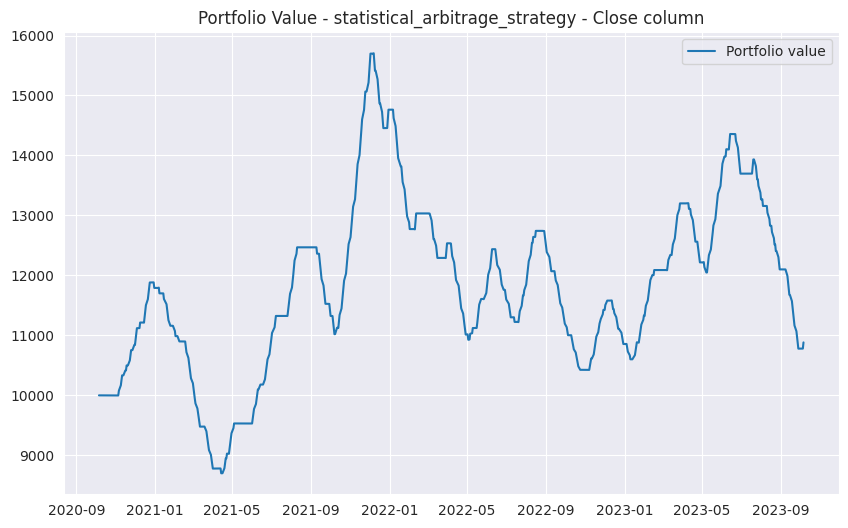

/tmp/ipykernel_20729/2280149294.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Position'].iloc[i] = data['Signal'].iloc[i-1]
/tmp/ipykernel_20729/2280149294.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Cash'].iloc[i] = data['Cash'].iloc[i-1] - (data['Signal'].iloc[i-1] * data[target_col].iloc[i-1])
/tmp/ipykernel_20729/2280149294.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Portfolio Value'].iloc[i]

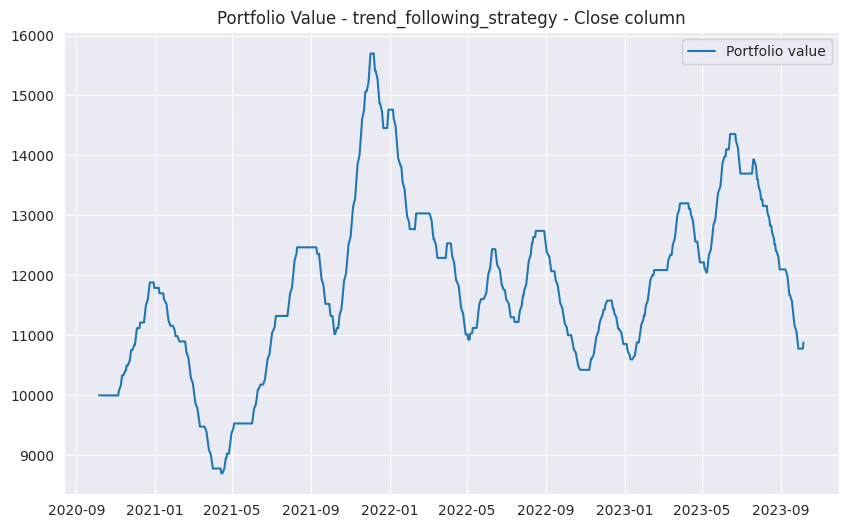

/tmp/ipykernel_20729/2280149294.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Position'].iloc[i] = data['Signal'].iloc[i-1]
/tmp/ipykernel_20729/2280149294.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Cash'].iloc[i] = data['Cash'].iloc[i-1] - (data['Signal'].iloc[i-1] * data[target_col].iloc[i-1])
/tmp/ipykernel_20729/2280149294.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Portfolio Value'].iloc[i]

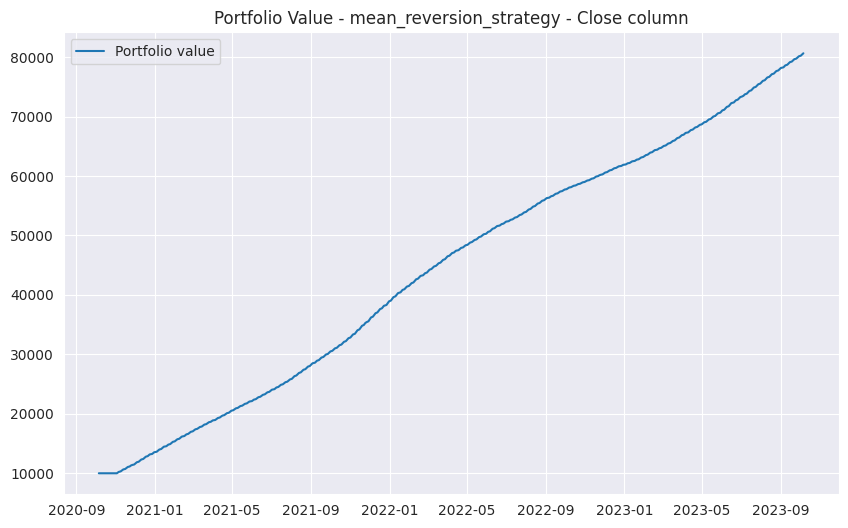

In [54]:
for strategy_func in [statistical_arbitrage_strategy, trend_following_strategy, mean_reversion_strategy]:
    analyze_strategy(strategy_func, df_merged, 'Close_AMD', 'Close_Intel')